# 1. Import thư viện

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from models.logistic_regression import LogisticRegression
from models.random_forest import RandomForest
from evaluator.evaluator import Evaluator

# 2. Các hằng số cần thiết

In [25]:
np.random.seed(42)
DATA_DIR = Path("../data")
FINAL_DATA_DIR = DATA_DIR / "final"

# 3. Load các tập dữ liệu

In [26]:
def load_data(file_path: Path):
    """
    Load preprocessed training and testing data from specified directory.

    Parameters:
    -----------
    file_path : Path
        Directory containing the numpy arrays

    Returns:
    --------
    tuple : (X_train, y_train, X_test, y_test)
        Training and testing features and labels
    """
    X_train = np.load(file_path / "X_train.npy")
    y_train = np.load(file_path / "y_train.npy")
    X_test = np.load(file_path / "X_test.npy")
    y_test = np.load(file_path / "y_test.npy")

    return X_train, y_train, X_test, y_test


# Dữ liệu gốc chưa xử lý cân bằng
original_X_train, original_y_train, original_X_test, original_y_test = load_data(
    FINAL_DATA_DIR / "original"
)

# Dữ liệu sau khi giảm mẫu (under-sampled)
under_sample_X_train, under_sample_y_train, under_sample_X_test, under_sample_y_test = (
    load_data(FINAL_DATA_DIR / "under_sampled")
)


print(f"Original dataset shapes:")
print(f"  Training: X={original_X_train.shape}, y={original_y_train.shape}")
print(f"  Testing:  X={original_X_test.shape}, y={original_y_test.shape}")
print(f"\nUnder-sampled dataset shapes:")
print(f"  Training: X={under_sample_X_train.shape}, y={under_sample_y_train.shape}")

Original dataset shapes:
  Training: X=(199364, 30), y=(199364,)
  Testing:  X=(85443, 30), y=(85443,)

Under-sampled dataset shapes:
  Training: X=(688, 30), y=(688,)


# 4. Metrics đánh giá

Các thang đo sẽ được sử dụng trong việc đánh giá mô hình:

- **Accuracy**: Mức độ chính xác tổng thể của mô hình.
- **Precision**: Tỷ lệ dự đoán dương tính đúng trên tổng số dự đoán dương tính (giảm cảnh báo giả).
- **Recall**: Tỷ lệ dự đoán dương tính đúng trên tổng số mẫu dương tính thực sự (quan trọng khi cần phát hiện gian lận).
- **F1-Score**: Trung bình điều hòa giữa Precision và Recall.
- **PR-AUC**: Diện tích dưới đường cong Precision–Recall (đặc biệt phù hợp cho tập dữ liệu mất cân bằng).


In [27]:
evaluator = Evaluator(metrics=["accuracy", "precision", "recall", "f1_score", "pr_auc"])

# 5. Huấn luyện mô hình

- Ta sẽ thực hiện việc đánh giá trên tập dữ liệu gốc chủ yếu trên mô hình đã được huấn luyện trên tập dữ liệu under-sampled.

## 5.1 Mô hình Logistic Regression

Mô hình Logistic Regression là một mô hình phân loại tuyến tính, ước lượng xác suất gian lận thông qua hàm sigmoid. Mặc dù đơn giản, logistic regression thường mang lại hiệu suất cơ sở mạnh mẽ cho các bài toán phân loại nhị phân.

**Hyperparameters:**
- Learning rate: 0.01  
- Số vòng lặp (iterations): 1000


In [28]:
lr_model = LogisticRegression(
    learning_rate=0.01,
    n_iterations=1000,
)

print("Huấn luyện Logistic Regression trên tập dữ liệu giảm mẫu...")
lr_model.fit(under_sample_X_train, under_sample_y_train)

Huấn luyện Logistic Regression trên tập dữ liệu giảm mẫu...


-- Logistic Regression Performance (Under-sampled Test Set) --
accuracy: 0.9392
precision: 0.9724
recall: 0.9097
f1_score: 0.9400
pr_auc: 0.9647


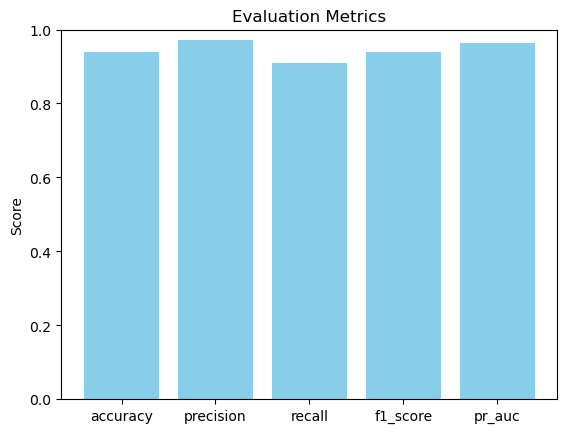

-- Logistic Regression Performance (Original Imbalanced Test Set) --
accuracy: 0.9481
precision: 0.0326
recall: 0.9430
f1_score: 0.0630
pr_auc: 0.4879


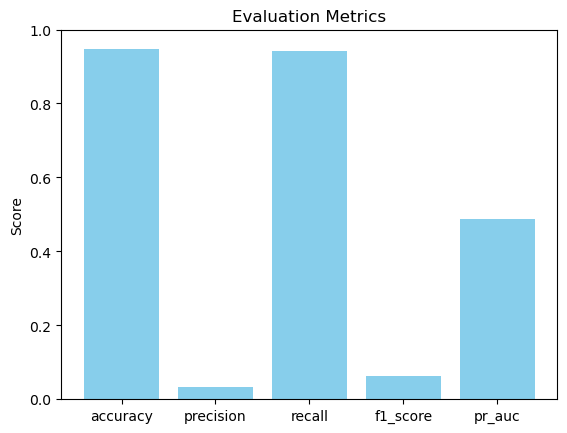

In [29]:
lr_under_pred = lr_model.predict(under_sample_X_test)

print("-- Logistic Regression Performance (Under-sampled Test Set) --")
lr_under_results = evaluator.evaluate(
    y_true=under_sample_y_test,
    y_pred=lr_under_pred,
    visualize=True,
)

lr_original_pred = lr_model.predict(original_X_test)

print("-- Logistic Regression Performance (Original Imbalanced Test Set) --")
lr_original_results = evaluator.evaluate(
    y_true=original_y_test,
    y_pred=lr_original_pred,
    visualize=True,
)

### Nhận xét
- Trên tập dữ liệu giảm mẫu:
    - Các chỉ số đều cao và cân bằng, đặc biệt là precision (~0.97) và recall (~0.91).
    - Điều này cho thấy khi dữ liệu được under-sampling để trở nên cân bằng, mô hình học ranh giới phân lớp rất tốt.
    - PR-AUC cao (~0.96) chứng minh mô hình vẫn giữ hiệu suất ổn ngay cả khi threshold thay đổi.
- Trên tập dữ liệu mất cân bằng gốc:
    - Accuracy nhìn cao (~0.95) nhưng vô nghĩa trong bài toán bị mất cân bằng.
    - Precision cực thấp (~0.03) → trong số các mẫu bị dự đoán là gian lận, chỉ 3% là thật.
    - Recall cao (~0.94) → mô hình hầu như bắt được toàn bộ các mẫu gian lận.
    - F1-score rất thấp (~0.06) → mất cân bằng nghiêm trọng giữa precision và recall.
    - PR-AUC (0.48) < 0.5 → mô hình gần như không tốt hơn random khi đánh đổi giữa precision–recall.


### Dự đoán
Do dữ liệu thật rất mất cân bằng, logistic regression nghiêng về việc dự đoán tất cả là “gian lận” để tối ưu recall → nhưng dẫn đến precision thấp.

## 5.2 Mô hình Random Forest

Random Forest là một phương pháp học ensemble, xây dựng nhiều cây quyết định trong giai đoạn huấn luyện và đưa ra dự đoán dựa trên kết quả biểu quyết của các cây. Mô hình đặc biệt hiệu quả trong việc xử lý các quan hệ phi tuyến và tương tác giữa các đặc trưng.

**Ưu điểm chính trong bài toán phát hiện gian lận:**
- Xử lý tốt các quan hệ phi tuyến trong dữ liệu  
- Mạnh mẽ trước nhiễu và các điểm ngoại lai  
- Tự động cung cấp mức độ quan trọng của đặc trưng 
- Giảm overfitting nhờ cơ chế lấy trung bình từ nhiều cây

### 5.2.1 Tham số gốc

In [30]:
rf_baseline = RandomForest(
    n_trees=10,
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    max_features="sqrt",
    random_state=42,
)

print("Huấn luyện Random Forest trên tập dữ liệu giảm mẫu...")
rf_baseline.fit(under_sample_X_train, under_sample_y_train),

Huấn luyện Random Forest trên tập dữ liệu giảm mẫu...


(<models.random_forest.RandomForest at 0x7f079edaea50>,)


-- Random Forest Baseline Performance (Under-sampled Test Set) --
accuracy: 0.9392
precision: 0.9724
recall: 0.9097
f1_score: 0.9400
pr_auc: 0.9647


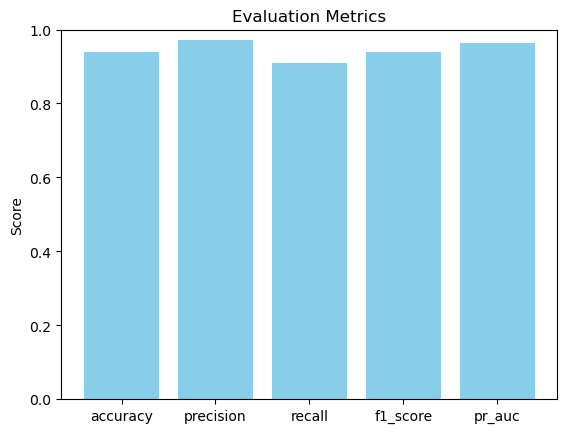

-- Random Forest Baseline Performance (Original Imbalanced Test Set) --
accuracy: 0.9622
precision: 0.0445
recall: 0.9494
f1_score: 0.0849
pr_auc: 0.4970


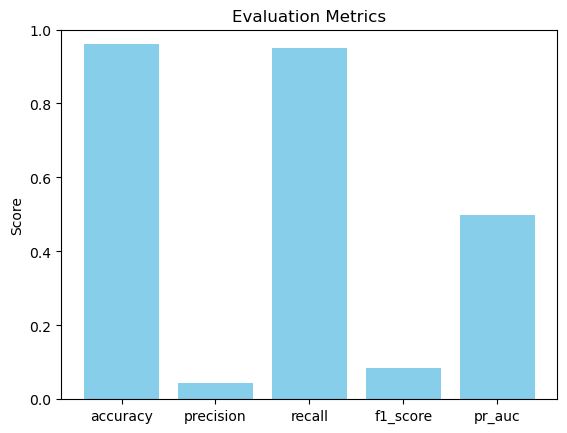

In [31]:
rf_under_pred = rf_baseline.predict(under_sample_X_test)

print("\n-- Random Forest Baseline Performance (Under-sampled Test Set) --")
rf_under_results = evaluator.evaluate(
    y_true=under_sample_y_test,
    y_pred=rf_under_pred,
    visualize=True,
)

rf_baseline_pred = rf_baseline.predict(original_X_test)

print("-- Random Forest Baseline Performance (Original Imbalanced Test Set) --")
rf_baseline_results = evaluator.evaluate(
    y_true=original_y_test,
    y_pred=rf_baseline_pred,
    visualize=True,
)

### Nhận xét
- Tương tự với Logistic Regression, Random Forest cũng đạt hiệu suất rất tốt trên tập dữ liệu đã được under-sampling, với các chỉ số precision, recall, F1 và PR-AUC đều cao và cân bằng. Điều này cho thấy mô hình hoạt động ổn khi phân phối dữ liệu được làm cân bằng nhân tạo.
- Tuy nhiên, khi đánh giá trên tập dữ liệu gốc vốn rất mất cân bằng, hiệu suất giảm mạnh — đặc biệt là precision thấp và PR-AUC chỉ khoảng 0.497, gần mức random. Điều này chứng tỏ mô hình không tổng quát tốt trên phân phối thật và tiếp tục gặp khó khăn trong việc xử lý thiên lệch lớp nặng.

### 5.2.2 Tham số lớn hơn

Dựa trên tham số gốc, ta sẽ thực hiện việc điều chỉnh tham số để kiểm tra kết quả:
- Tăng số lượng cây.
- Tăng chiều sâu tối đa. \
...

In [32]:
rf_optimized = RandomForest(
    n_trees=50,
    max_depth=15,
    min_samples_split=5,
    min_samples_leaf=2,
    max_features="sqrt",
    random_state=42,
)

print("Huấn luyện Random Forest tối ưu trên tập dữ liệu giảm mẫu...")
rf_optimized.fit(under_sample_X_train, under_sample_y_train)

Huấn luyện Random Forest tối ưu trên tập dữ liệu giảm mẫu...



-- Optimized Random Forest Performance (Under-sampled Test Set) --
accuracy: 0.9426
precision: 0.9929
recall: 0.8968
f1_score: 0.9424
pr_auc: 0.9718


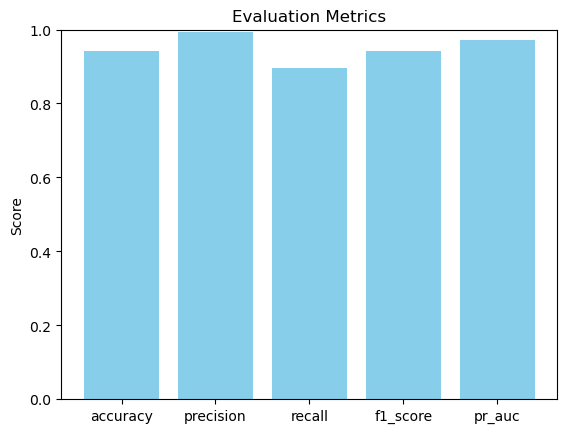


-- Optimized Random Forest Performance (Original Imbalanced Test Set) --
accuracy: 0.9802
precision: 0.0823
recall: 0.9557
f1_score: 0.1516
pr_auc: 0.5191


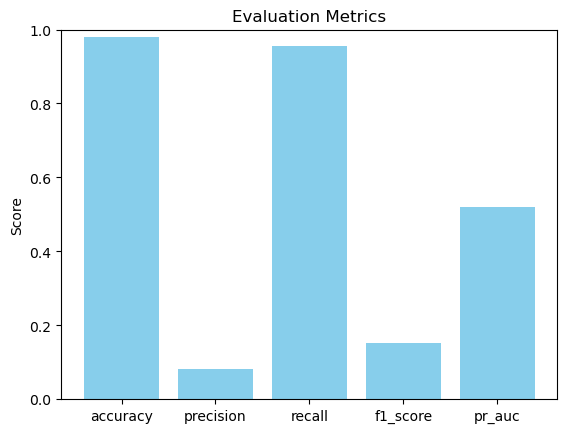

In [33]:
rf_opt_under_pred = rf_optimized.predict(under_sample_X_test)
print("\n-- Optimized Random Forest Performance (Under-sampled Test Set) --")
rf_opt_under_results = evaluator.evaluate(
    y_true=under_sample_y_test,
    y_pred=rf_opt_under_pred,
    visualize=True,
)


rf_opt_pred = rf_optimized.predict(original_X_test)

print("\n-- Optimized Random Forest Performance (Original Imbalanced Test Set) --")
rf_opt_results = evaluator.evaluate(
    y_true=original_y_test,
    y_pred=rf_opt_pred,
    visualize=True,
)

### Nhận xét
- Mô hình Random Forest sau khi tăng số lượng cây (và các tham số khác) tiếp tục đạt hiệu suất rất tốt trên tập dữ liệu đã được under-sampling, với precision gần như tuyệt đối (0.9929), F1-score cao và PR-AUC đạt 0.9718. Điều này cho thấy mô hình có khả năng học biên phân lớp trong môi trường cân bằng một cách mạnh mẽ hơn so với phiên bản ban đầu.
- Tuy nhiên, khi đánh giá trên tập dữ liệu gốc vốn mất cân bằng, hiệu suất vẫn giảm đáng kể. Precision chỉ còn 0.0823 và F1-score 0.1516 — tốt hơn so với Random Forest gốc nhưng vẫn không đạt mức chấp nhận được cho bài toán fraud detection. PR-AUC cải thiện lên 0.5191, nhỉnh hơn một chút so với 0.4970 trước đó, nhưng vẫn chỉ ở mức vừa đủ và chưa tạo ra khác biệt đáng kể.

# 6. Vấn đề gặp phải

- Dữ liệu cực kỳ mất cân bằng chưa được xử lý đầy đủ: việc chỉ áp dụng giảm mẫu làm giảm đáng kể dữ liệu lớp đa số, dẫn đến mất thông tin và khiến mô hình khó tổng quát hóa trên phân phối thật.
- Chưa thử nghiệm các kỹ thuật xử lý mất cân bằng tiên tiến: các phương pháp như SMOTE, ADASYN, ... chưa được triển khai, hạn chế khả năng cải thiện kết quả trên các thang đo.
- Chỉ mới thực hiện đánh giá trên mô hình tuyến tính và cây quyết định: có những mô hình mạnh hơn, chuyên biệt cho bài toán với dữ liệu mất cân bằng (XGBoost, LightBGM).

# 7. Tổng kết

- Trong bài báo cáo này, ta thấy được hiệu suất của ba mô hình học máy—Logistic Regression, Random Forest và Optimized Random Forest—trên bài toán phát hiện gian lận với một tập dữ liệu có mức mất cân bằng nghiêm trọng. Kết quả thực nghiệm cho thấy under-sampling mang đến các chỉ số đánh giá rất cao trên tập dữ liệu cân bằng, nhưng những kết quả này không phản ánh đúng khả năng tổng quát hóa của mô hình trên phân phối dữ liệu thật.
- Trên tập dữ liệu gốc, cả Logistic Regression và Random Forest đều đạt accuracy cao nhưng precision rất thấp, dẫn đến F1-score thấp và hiệu suất tổng thể không phù hợp cho nhiệm vụ phát hiện gian lận. Mặc dù Random Forest sau khi tối ưu (tăng số lượng cây và điều chỉnh tham số) cho thấy sự cải thiện nhỏ — thể hiện qua việc PR-AUC tăng từ ~0.4970 lên ~0.5191 — mức cải thiện này vẫn không đủ để mô hình trở nên khả dụng trong thực tế. Điều này khẳng định rằng tăng độ phức tạp mô hình không giải quyết được căn nguyên của vấn đề, đó là sự mất cân bằng nghiêm trọng của dữ liệu.